In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
from sklearn.metrics import mean_absolute_error

In [102]:
# 1. Bitcoin price
btc = yf.download('BTC-USD', start='2020-01-01', end='2024-01-01')['Close']

# 2. log return
returns = np.log(btc / btc.shift(1)).dropna()

[*********************100%***********************]  1 of 1 completed


In [103]:
returns = returns.asfreq('D')

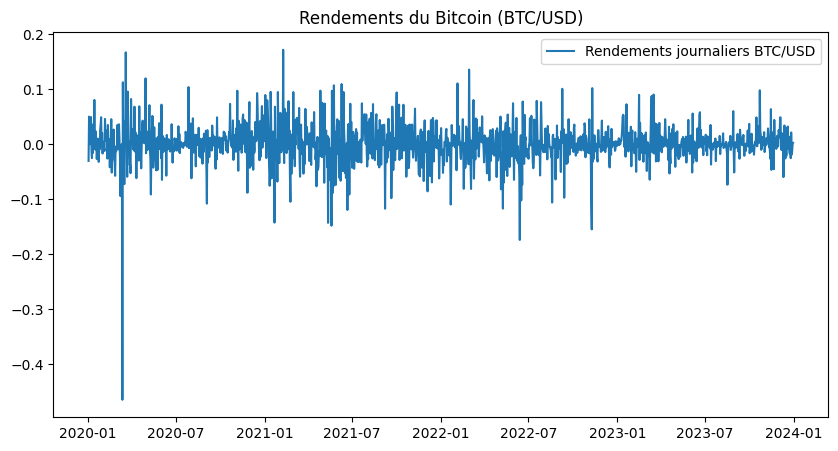

In [104]:
# 4. Visualisation des rendements
plt.figure(figsize=(10, 5))
plt.plot(returns, label="Rendements journaliers BTC/USD")
plt.title("Rendements du Bitcoin (BTC/USD)")
plt.legend()
plt.show()

In [105]:
train_size = int(len(returns) * 0.75)  # 75% des données pour l'entraînement
train, test = returns[:train_size], returns[train_size:]

In [106]:
# 3. Test de stationnarité ADF
adf_test = adfuller(train)

print("Résultat du test ADF :")
print(f"Statistique ADF : {adf_test[0]}")
print(f"p-valeur : {adf_test[1]}")
print("Seuils critiques :", adf_test[4])

Résultat du test ADF :
Statistique ADF : -10.669771471335434
p-valeur : 4.196297345647625e-19
Seuils critiques : {'1%': -3.4363857496063455, '5%': -2.8642050392821794, '10%': -2.5681889563132314}


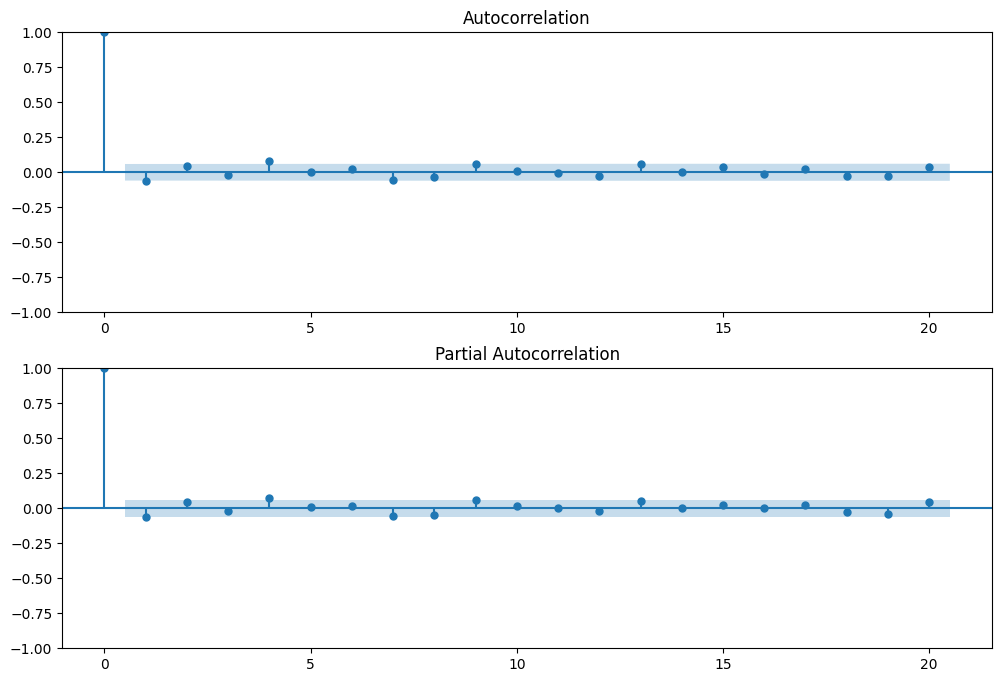

In [107]:
# Tracer ACF et PACF
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(train, ax=ax[0], lags=20)
plot_pacf(train, ax=ax[1], lags=20)
plt.show()

In [108]:
p_range = range(0, 4)  # Augmenté pour tester plus de valeurs
q_range = range(0, 4)
best_aic = float('inf')
best_order = None
best_model = None

# 6️⃣ Tester toutes les combinaisons de p et q
for p, q in itertools.product(p_range, q_range):
    try:
        model = ARIMA(train, order=(p, 0, q))  # d=0 car ARMA
        result = model.fit()
        if result.aic < best_aic:
            best_aic = result.aic
            best_order = (p, q)
            best_model = result
    except:
        continue

print(f"✅ Meilleur modèle ARMA : {best_order} avec AIC = {best_aic}")

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


✅ Meilleur modèle ARMA : (1, 1) avec AIC = -4009.337674512151


In [109]:
best_model = ARIMA(train, order=(1, 0, 1))
best_result = best_model.fit()

# Résumé du modèle
print(best_result.summary())

                               SARIMAX Results                                
Dep. Variable:                BTC-USD   No. Observations:                 1095
Model:                 ARIMA(1, 0, 1)   Log Likelihood                2008.669
Date:                Sun, 23 Feb 2025   AIC                          -4009.338
Time:                        08:42:24   BIC                          -3989.344
Sample:                    01-02-2020   HQIC                         -4001.772
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      0.620      0.535      -0.002       0.003
ar.L1         -0.7364      0.134     -5.492      0.000      -0.999      -0.474
ma.L1          0.6746      0.147      4.602      0.0

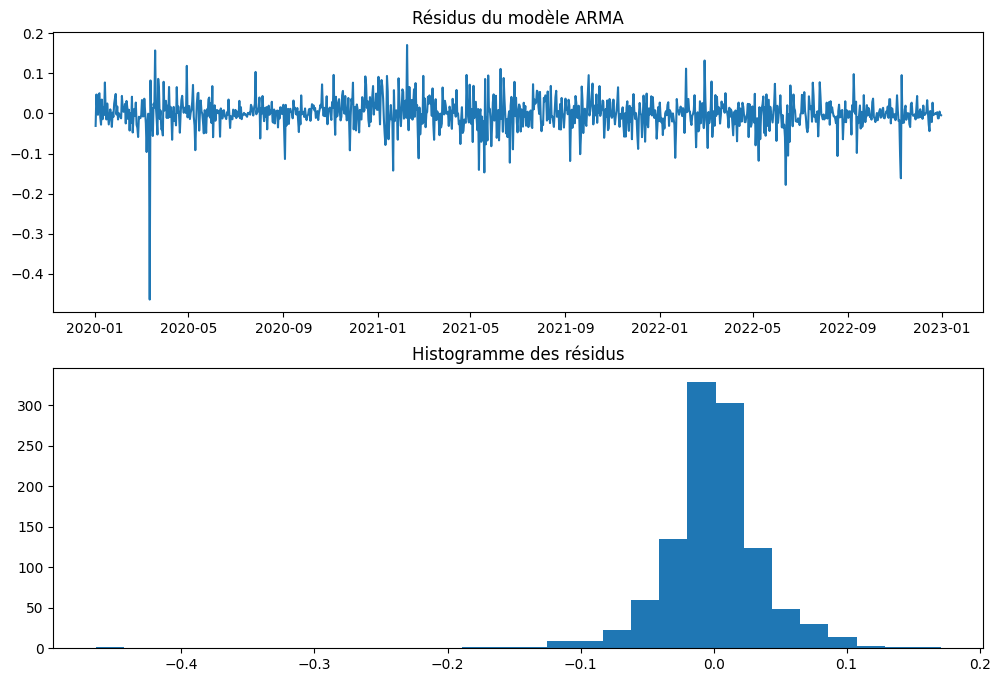

In [110]:
# Tracer les résidus
residuals = best_result.resid

fig, ax = plt.subplots(2, 1, figsize=(12, 8))
ax[0].plot(residuals)
ax[0].set_title('Résidus du modèle ARMA')
ax[1].hist(residuals, bins=30)
ax[1].set_title('Histogramme des résidus')
plt.show()


In [111]:
print(returns.columns)


Index(['BTC-USD'], dtype='object', name='Ticker')


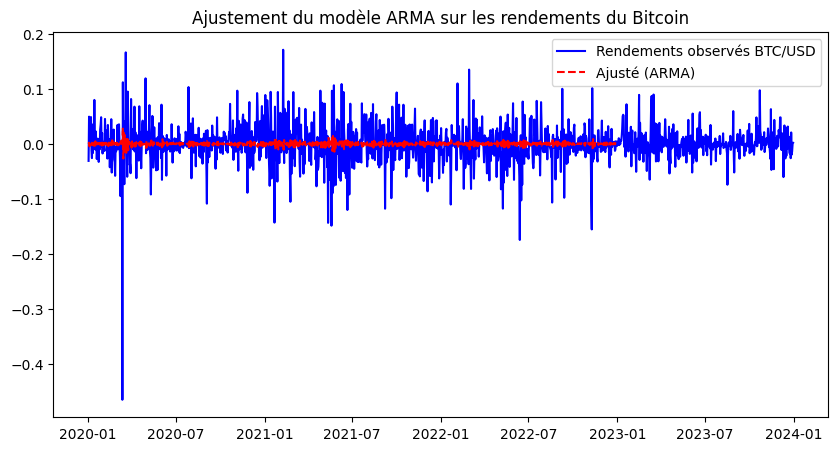

In [112]:
# 7. Affichage des valeurs ajustées
returns['Fitted'] = best_result.fittedvalues

plt.figure(figsize=(10, 5))
plt.plot(returns.index, returns['BTC-USD'], label="Rendements observés BTC/USD", color="blue")
plt.plot(returns.index, returns['Fitted'], label="Ajusté (ARMA)", linestyle='dashed', color="red")
plt.title("Ajustement du modèle ARMA sur les rendements du Bitcoin")
plt.legend()
plt.show()

In [113]:
predictions = best_result.forecast(steps=len(test))

# 8️⃣ Évaluer la performance
mae = mean_absolute_error(test, predictions)
print(f"📉 Erreur MAE : {mae:.6f}")

📉 Erreur MAE : 0.015271


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


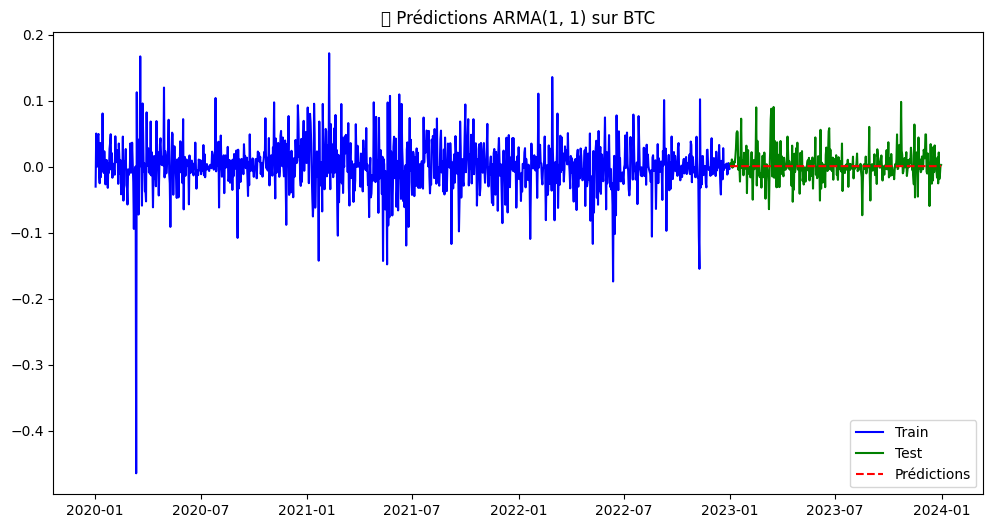

In [114]:
plt.figure(figsize=(12, 6))
plt.plot(train, label="Train", color="blue")
plt.plot(test, label="Test", color="green")
plt.plot(test.index, predictions, label="Prédictions", color="red", linestyle="dashed")
plt.legend()
plt.title(f"📈 Prédictions ARMA{best_order} sur BTC")
plt.show()

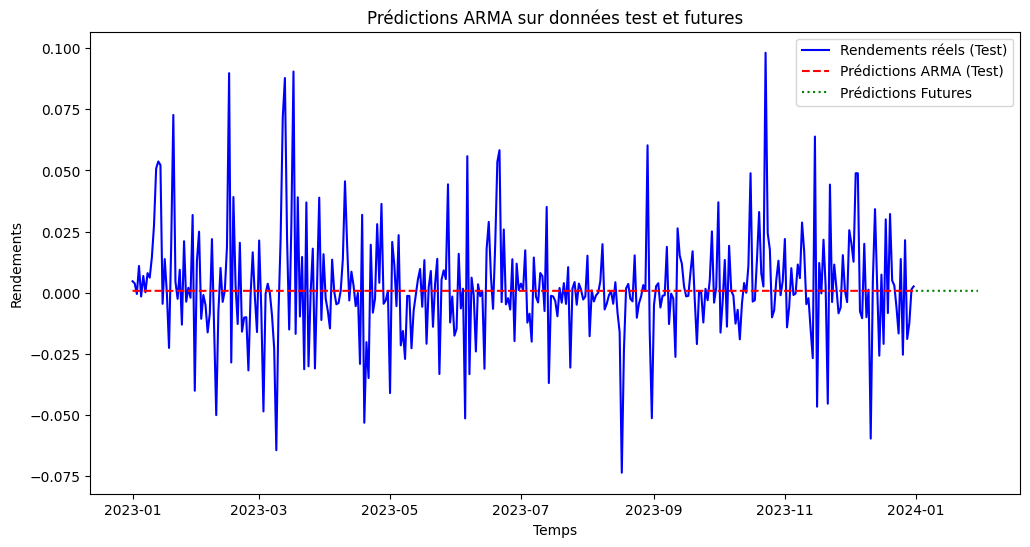

In [115]:
# Définir l'horizon de prévision (ex: 30 jours)
horizon = 30

# Faire une prévision sur 30 jours après la partie test
future_predictions = best_result.forecast(steps=horizon)

# Créer un index temporel pour les prévisions futures
future_index = pd.date_range(start=test.index[-1], periods=horizon+1, freq='D')[1:]

# Tracer les prédictions futures
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label="Rendements réels (Test)", color="blue")
plt.plot(test.index, predictions, label="Prédictions ARMA (Test)", color="red", linestyle="dashed")
plt.plot(future_index, future_predictions, label="Prédictions Futures", color="green", linestyle="dotted")
plt.title("Prédictions ARMA sur données test et futures")
plt.xlabel("Temps")
plt.ylabel("Rendements")
plt.legend()
plt.show()
